In [1]:
from brainiak.factoranalysis.tfa import TFA
from brainiak.factoranalysis.htfa import HTFA
import hypertools as hyp
import nilearn.plotting as niplot
from nilearn.input_data import NiftiMasker
import nibabel as nib
import wget
import zipfile
import os
import glob
from IPython.display import YouTubeVideo
import numpy as np
import seaborn as sns

%matplotlib inline

/opt/conda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Background and overview #

We'll be learning how to create movies of dynamic brain networks using single-subject and multi-subject fMRI data.  After getting the dataset and wrangling it into the proper format, there are three basic steps:
1. Use Hierarchical Topographic Factor Analysis (HTFA) to obtain a set of network "hubs," and the moment-by-moment hub activations.  Model details may be found [here](http://www.biorxiv.org/content/early/2017/02/07/106690).  This creates a simplified version of the full-brain data that is especially useful for computing dynamic network patterns.
1. Use the hub activactions to compute the moment-by-moment connectivity matrix reflected by the data.  We will be using a modified version of Inter-Subject Functional Connectivity (ISFC), which you can read more about [here](https://docs.wixstatic.com/ugd/b75639_92eab30b43284ca0bd163e3daa709eda.pdf).
1. Use [nilearn](http://nilearn.github.io/) and [hypertools](http://hypertools.readthedocs.io/en/latest/) to visualize the results and create pretty animations.

## Experiment ##
We'll be exploring a part of a dataset collected by Uri Hasson's lab.  The experiment had 36 participants listen *Pie Man*, a story told by Jim O'Grady as part of *The Moth* live storytelling event.  You can listen to the story here:

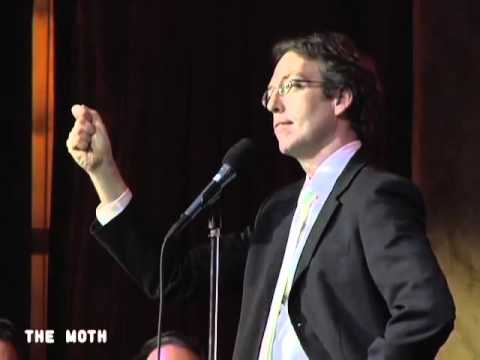

In [9]:
YouTubeVideo('3nZzSUDECLo')

## Data ##
The dataset comprises 36 preprocessed .nii files, and may be downloaded [here](http://dataspace.princeton.edu/jspui/handle/88435/dsp015d86p269k).  However, in the interest of running the analyses quickly, for this tutorial we're going to be working with data from just 4 participants participants.  This smaller dataset may be downloaded [here](https://dartmouth.box.com/s/535yzfqvsmfdiy9jrl65bb5x6rtc7ss4).

## Other datasets to explore ##
[This repository](http://dataspace.princeton.edu/jspui/handle/88435/dsp0147429c369) has a bunch of interesting fMRI datasets in the same format as the sample dataset we'll explore below.

[This dataset](https://dartmouth.box.com/s/gs30hsyk6gsmr8oe5993fr10kuacluo7) collected by Jim Haxby's lab comprises fMRI data as people watched *Indiana Jones: Raiders of the Lost Ark*.



In [2]:
#Download the data (takes a few minutes...)
source = '....'
destination = '/mnt/mini_raiders.zip'

#FIGURE OUT HOW TO DOWNLOAD FROM BOX OR DROPBOX...

In [3]:
#Unzip the data
#zipfile.ZipFile(destination, 'r').extractall()
niifiles = glob.glob(os.path.join(destination[0:-4], '*.nii.gz'))

### Data formatting: .nii --> matrix format ###
To computing HTFA-derived brain networks, we're going to first convert the .nii files into [CMU format](http://www.cs.cmu.edu/afs/cs/project/theo-73/www/science2008/README-data-documentation.txt), inspired by Tom Mitchell's website for his 2008 Science paper on predicting brain responses to common nouns ([link](http://www.cs.cmu.edu/afs/cs/project/theo-73/www/science2008/data.html)).

We'll create a dictionary for each .nii (or .nii.gz) file with two elements:
- `Y`: a number-of-timepoints by number-of-voxels matrix of voxel activations
- `R`: a number-of-voxels by 3 matrix of voxel locations

In [8]:
def nii2cmu(nifti_file, mask_file, zscore, detrend, smoothing_fwmw):
    if mask_file is None:
        #whole brain, get coordinate info from nifti_file itself
        mask = nib.load(nifti_file)
    else:
        mask = nib.load(mask_file)
    affine = mask.affine
    if mask_file is None:
        mask_data = mask.get_data()
        if mask_data.ndim == 4:
            #get mask in 3D
            img_data_type = mask.header.get_data_dtype()
            n_tr = mask_data.shape[3]
            mask_data = mask_data[:,:,:,n_tr//2].astype(bool)
            mask = nib.Nifti1Image(mask_data.astype(img_data_type), affine)
        else:
            mask_data = mask_data.astype(bool)
    else:
        mask_data = mask.get_data().astype(bool)

    #get voxel coordinates
    R = np.float64(np.argwhere(mask_data))

    #get scanner RAS coordinates based on voxel coordinates
    if affine is not []:
        R = (np.dot(affine[:3,:3], R.T) + affine[:3,3:4]).T

    #get ROI data, and run preprocessing
    nifti_masker = NiftiMasker(mask_img=mask, standardize=zscore, detrend=detrend, smoothing_fwhm=smoothing_fwmw)
    img = nib.load(nifti_file)
    all_images = np.float64(nifti_masker.fit_transform(img))
    data = all_images.copy()

    return {'Y': data, 'R': R}

In [9]:
mask_file = None #optionally specify a mask to apply to the images
zscore = True #z-score the data (within voxel)?
detrend = True #de-trend the data?
smoothing_fwmw = False #smooth the data?  (this specifies the smoothing radius)

cmu_data = list(map(lambda n: nii2cmu(n, mask_file, zscore, detrend, smoothing_fwmw),  niifiles[0:3]))

## Voxel locations

We can get explore the nitty-gritties of the data by visualizaing the voxel activations and voxel locations.  For example, let's try plotting the voxel locations (`R`) for the first subject:

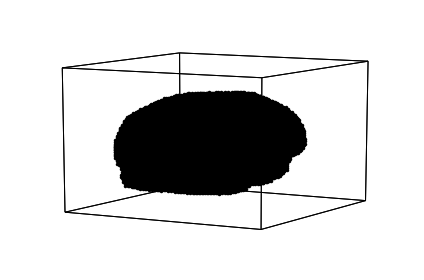

In [6]:
locations = hyp.plot(cmu_data[0]['R'], 'k.') #fun fact: also returns the voxel locations

## Voxel activations

And now let's plot a sample of voxel activations.  For fun, let's plot the first subject's data as a trajectory using HyperTools.  We'll first project the data down to 3 dimensions using Incremental PCA.  HyperTools supports a wide variety of dimensionality reduction algorithms (more info [here](http://hypertools.readthedocs.io/en/latest/hypertools.plot.html#hypertools.plot)).  Try changing the next cell to reduce the data using Multidimensional Scaling (hint: `model='MDS'`).

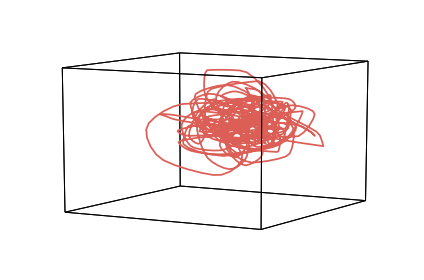

In [10]:
activations = hyp.plot(cmu_data[0]['Y'], model='IncrementalPCA')

## Converting between (timepoints by voxels) and (voxels by timepoints) data matrices ##

HyperTools and nilearn expect the data matrices to have number-of-timepoints rows and number-of-voxels columns.  BrainIAK expects the data in the transpose of that format-- number-of-voxels by number-of-timepoints matrices.  We can easily convert between the two formats using the `map` function.

In [11]:
htfa_data = list(map(lambda x: {'R': x['R'], 'Z': x['Y'].T}, cmu_data))

# Using Topographic Factor Analysis to finding network "hubs" in one subject's data #

Applying [Topographic Factor Analysis](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0094914) (TFA) to a single subject's data reveals a set of `K` spherical network hubs that may be used to characterize the data in a highly compact form that is convenient for summarizing network patterns.  Let's apply TFA to one subject's data and plot the resulting network hubs.

In [14]:
nvoxels, ntimepoints = htfa_data[0]['Z'].shape
K = 10 #number of hubs to find
tfa = TFA(K=K,
          max_num_voxel=int(nvoxels*0.1),    #parameterizes the stochastic sampler (number of voxels to consider in each update); increase for precision, decrease for speed
          max_num_tr = int(ntimepoints*0.1), #parameterizes the stochastic sampler (number of timepoints to consider in each update)
          verbose=False)

tfa.fit(htfa_data[0]['Z'], htfa_data[0]['R'])

TFA(K=10, jac='2-point', lower_ratio=0.02, max_iter=None, max_num_tr=33,
  max_num_voxel=7862, nlss_loss='soft_l1', nlss_method='trf', seed=100,
  threshold=1.0, tr_solver=None, upper_ratio=1.8, verbose=False,
  weight_method='rr', x_scale='jac')

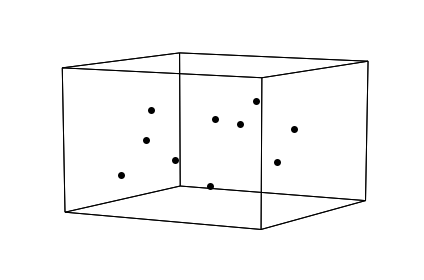

(<matplotlib.figure.Figure at 0x7f0f670bcba8>,
 [array([[ -6.15199655, -62.02946074,  44.62609763],
         [-34.96049206,  -9.83383605,  62.86960481],
         [ 20.43037496,  75.91292861,  37.04724079],
         [-30.33217286,  60.71297441,  44.72733422],
         [ 16.39533031,  31.75328271,  70.77215775],
         [ 25.10551553, -40.12564791,   1.2204188 ],
         [-33.29188281,  16.097625  ,   9.83632216],
         [-37.37264014, -42.18979185,   5.33502719],
         [ 36.88409872,  22.24542194,  13.91270075],
         [ 35.90305312, -23.47689794,  57.50060878]])],
 None)

In [15]:
hyp.plot(tfa.get_centers(tfa.local_posterior_), 'ko')

## Compare the original vs. TFA-reduced data trajectories

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


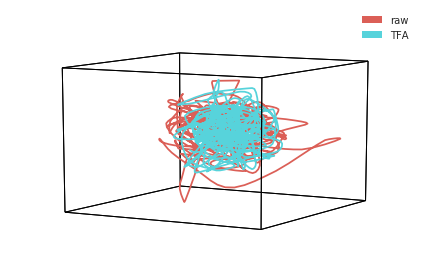

In [21]:
reduced_raw = hyp.tools.reduce(cmu_data[0]['Y'], ndims=10)
reduced_tfa = tfa.W_.T

reduced_aligned_data = hyp.plot([reduced_raw, reduced_tfa], align=True, legend=['raw', 'TFA'], model='MDS')

# Using Hierarchical Topographic Factor Analysis to finding network "hubs" in multi-subject data #

Applying [Hierarchical Topographic Factor Analysis](http://www.biorxiv.org/content/early/2017/02/07/106690) (HTFA) to a multi-subject dataset reveals a set of `K` spherical network hubs analogous to the hubs revealed by TFA.  However, HTFA finds a set of hubs that are common across all of the subjects.  Specifically, HTFA finds a common **global template** of K hubs that every subject's data reflects.  In addition, HTFA finds a **subject-specific template** (also called a **local template**) that is particular to each individual subject.  The subject-specific template specifies how each individual is *different* from the global template.

Often we want to know something about how people "in general" respond to a given experiment, so that's the scenario we'll explore here (via the global template).  However, it is sometimes interesting to also explore individual differences using the local templates.

Note: the multi-subject HTFA inference problem is substantially more computationally intensive than the single-subject TFA inference problem.  Therefore this computation is likely to take some time to complete.

In [29]:
Zs = list(map(lambda x: x['Z'], htfa_data))
Rs = list(map(lambda x: x['R'], htfa_data))

htfa = HTFA(K=K,
            max_global_iter=5,
            max_local_iter=2,
            voxel_ratio=0.1,
            tr_ratio=0.1,
            max_voxel=np.max(list(map(lambda x: x.shape[0], Rs))), #set to the maximum number of voxels from any subject
            max_tr=ntimepoints,
            verbose=False)
htfa.fit(Zs, Rs)

Exception: Message truncated, error stack:
PMPI_Gather(904)......: MPI_Gather(sbuf=0x4087fd0, scount=120, MPI_DOUBLE, rbuf=0x48704a0, rcount=80, MPI_DOUBLE, root=0, MPI_COMM_WORLD) failed
MPIR_Gather_impl(726).: 
MPIR_Gather(686)......: 
MPIR_Gather_intra(187): 
MPIR_Localcopy(74)....: Message truncated; 960 bytes received but buffer size is 640